In [ ]:
# Komórka 1 - Dzielenie i wczytywanie sygnałów:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 4)

BASELINE_LEN_S   = 0.5
SMOOTH_LEN_S     = 0.05
STD_THRESHOLD    = 3.0
DELAY_AFTER_JUMP = 1.0
WINDOW_LEN_S     = 12.0

LSB_TO_G = 0.0039

BASE = Path(".")

CONDITION_DIRS = {
    "nieuszkodzone": "fabryczne_nieuszkodzone",
    "uszkodzone":    "fabryczne_uszkodzone",
}

PWM_DIRS = ["pwm_20%", "pwm_30%", "pwm_40%", "pwm_50%"]


def load_xyz_from_csv(path, return_rpm=False):
    """Wczytaj t, X, Y, Z z pliku CSV i przelicz na g.
       Jeśli return_rpm=True, zwróć także wektor rpm (lub None)."""
    df = pd.read_csv(path)
    cols_lower = {c.lower(): c for c in df.columns}

    time_col = None
    for key, orig in cols_lower.items():
        if "time" in key or "czas" in key:
            time_col = orig
            break

    x_col = y_col = z_col = None
    for key, orig in cols_lower.items():
        if x_col is None and key.startswith("x"):
            x_col = orig
        if y_col is None and key.startswith("y"):
            y_col = orig
        if z_col is None and key.startswith("z"):
            z_col = orig

    if time_col is None or x_col is None or y_col is None or z_col is None:
        raise ValueError(
            f"Nie mogę automatycznie znaleźć kolumn w pliku {path}.\n"
            f"Znalezione kolumny: {df.columns.tolist()}"
        )

    rpm = None
    if return_rpm:
        rpm_col = None
        for key, orig in cols_lower.items():
            if "rpm" in key:
                rpm_col = orig
                break
        if rpm_col is not None:
            rpm = df[rpm_col].to_numpy()

    t  = df[time_col].to_numpy()
    ax = df[x_col].to_numpy() * LSB_TO_G
    ay = df[y_col].to_numpy() * LSB_TO_G
    az = df[z_col].to_numpy() * LSB_TO_G

    dt = np.mean(np.diff(t))
    Fs = 1.0 / dt

    if return_rpm:
        return t, ax, ay, az, Fs, rpm
    else:
        return t, ax, ay, az, Fs



def detect_steady_window(t, ax, ay, az,
                         baseline_len_s=BASELINE_LEN_S,
                         smooth_len_s=SMOOTH_LEN_S,
                         std_threshold=STD_THRESHOLD,
                         delay_after_jump=DELAY_AFTER_JUMP,
                         window_len_s=WINDOW_LEN_S):
    mag = np.sqrt(ax**2 + ay**2 + az**2)

    t0 = t[0]
    baseline_mask = t <= (t0 + baseline_len_s)
    baseline = mag[baseline_mask]
    mu = baseline.mean()
    sigma = baseline.std()
    thresh = mu + std_threshold * sigma

    dt = np.mean(np.diff(t))
    Fs = 1.0 / dt
    win_samples = int(round(smooth_len_s * Fs))
    if win_samples < 1:
        win_samples = 1
    kernel = np.ones(win_samples) / win_samples
    mag_smooth = np.convolve(mag, kernel, mode="same")

    idx_candidates = np.where(mag_smooth > thresh)[0]
    if len(idx_candidates) == 0:
        t_start = t0 + 1.0
    else:
        idx_event = idx_candidates[0]
        t_event = t[idx_event]
        t_start = t_event + delay_after_jump

    t_end = t_start + window_len_s

    if t_end > t[-1]:
        t_end = t[-1]
        t_start = t_end - window_len_s
        if t_start < t0:
            t_start = t0

    mask_seg = (t >= t_start) & (t <= t_end)

    return (t[mask_seg],
            ax[mask_seg],
            ay[mask_seg],
            az[mask_seg],
            (t_start, t_end),
            mag,
            mag_smooth,
            thresh)


file_entries = []

for cond_label, cond_dir_name in CONDITION_DIRS.items():
    for pwm_dir in PWM_DIRS:
        dir_path = BASE / cond_dir_name / pwm_dir
        for csv_path in sorted(dir_path.glob("*.csv")):
            stem = csv_path.stem

            # pomiary 3200Hz na razie pomijamy
            if stem.startswith("3200Hz"):
                continue

            try:
                rep = int(stem.split("_")[0])
            except ValueError:
                rep = None

            pwm_val = int(pwm_dir.replace("pwm_", "").replace("%", ""))

            file_entries.append({
                "path": csv_path,
                "file_id": str(csv_path),
                "condition": cond_label,
                "pwm": pwm_val,
                "rep": rep,
            })

files_df = pd.DataFrame(file_entries)
print(f"Znaleziono {len(files_df)} plików (bez 3200Hz_*):")
display(files_df)

# szybkie sprawdzenie wycinania ustalonej pracy
for idx, row in files_df.iterrows():
    path = row["path"]
    t, ax, ay, az, Fs = load_xyz_from_csv(path)
    t_seg, ax_seg, ay_seg, az_seg, (t_start, t_end), mag, mag_smooth, thresh = \
        detect_steady_window(t, ax, ay, az)


Znaleziono 40 plików (bez 3200Hz_*):


path  \
0   fabryczne_nieuszkodzone\pwm_20%\1_fabryczne_ni...   
1   fabryczne_nieuszkodzone\pwm_20%\2_fabryczne_ni...   
2   fabryczne_nieuszkodzone\pwm_20%\3_fabryczne_ni...   
3   fabryczne_nieuszkodzone\pwm_20%\4_fabryczne_ni...   
4   fabryczne_nieuszkodzone\pwm_20%\5_fabryczne_ni...   
5   fabryczne_nieuszkodzone\pwm_30%\1_fabryczne_ni...   
6   fabryczne_nieuszkodzone\pwm_30%\2_fabryczne_ni...   
7   fabryczne_nieuszkodzone\pwm_30%\3_fabryczne_ni...   
8   fabryczne_nieuszkodzone\pwm_30%\4_fabryczne_ni...   
9   fabryczne_nieuszkodzone\pwm_30%\5_fabryczne_ni...   
10  fabryczne_nieuszkodzone\pwm_40%\1_fabryczne_ni...   
11  fabryczne_nieuszkodzone\pwm_40%\2_fabryczne_ni...   
12  fabryczne_nieuszkodzone\pwm_40%\3_fabryczne_ni...   
13  fabryczne_nieuszkodzone\pwm_40%\4_fabryczne_ni...   
14  fabryczne_nieuszkodzone\pwm_40%\5_fabryczne_ni...   
15  fabryczne_nieuszkodzone\pwm_50%\1_fabryczne_ni...   
16  fabryczne_nieuszkodzone\pwm_50%\2_fabryczne_ni...   
17  fabryczne_nieuszkodzone\pwm_50%\3_fabryczne_ni...   
18  fabryczne_nieuszkodzone\pwm_50%\4_fabryczne_ni...   
19  fabryczne_nieuszkodzone\pwm_50%\5_fabryczne_ni...   
20  fabryczne_uszkodzone\pwm_20%\1_fabryczne_uszko...   
21  fabryczne_uszkodzone\pwm_20%\2_fabryczne_uszko...   
22  fabryczne_uszkodzone\pwm_20%\3_fabryczne_uszko...   
23  fabryczne_uszkodzone\pwm_20%\4_fabryczne_uszko...   
24  fabryczne_uszkodzone\pwm_20%\5_fabryczne_uszko...   
25  fabryczne_uszkodzone\pwm_30%\1_fabryczne_uszko...   
26  fabryczne_uszkodzone\pwm_30%\2_fabryczne_uszko...   
27  fabryczne_uszkodzone\pwm_30%\3_fabryczne_uszko...   
28  fabryczne_uszkodzone\pwm_30%\4_fabryczne_uszko...   
29  fabryczne_uszkodzone\pwm_30%\5_fabryczne_uszko...   
30  fabryczne_uszkodzone\pwm_40%\1_fabryczne_uszko...   
31  fabryczne_uszkodzone\pwm_40%\2_fabryczne_uszko...   
32  fabryczne_uszkodzone\pwm_40%\3_fabryczne_uszko...   
33  fabryczne_uszkodzone\pwm_40%\4_fabryczne_uszko...   
34  fabryczne_uszkodzone\pwm_40%\5_fabryczne_uszko...   
35  fabryczne_uszkodzone\pwm_50%\1_fabryczne_uszko...   
36  fabryczne_uszkodzone\pwm_50%\2_fabryczne_uszko...   
37  fabryczne_uszkodzone\pwm_50%\3_fabryczne_uszko...   
38  fabryczne_uszkodzone\pwm_50%\4_fabryczne_uszko...   
39  fabryczne_uszkodzone\pwm_50%\5_fabryczne_uszko...   

                                              file_id      condition  pwm  rep  
0   fabryczne_nieuszkodzone\pwm_20%\1_fabryczne_ni...  nieuszkodzone   20    1  
1   fabryczne_nieuszkodzone\pwm_20%\2_fabryczne_ni...  nieuszkodzone   20    2  
2   fabryczne_nieuszkodzone\pwm_20%\3_fabryczne_ni...  nieuszkodzone   20    3  
3   fabryczne_nieuszkodzone\pwm_20%\4_fabryczne_ni...  nieuszkodzone   20    4  
4   fabryczne_nieuszkodzone\pwm_20%\5_fabryczne_ni...  nieuszkodzone   20    5  
5   fabryczne_nieuszkodzone\pwm_30%\1_fabryczne_ni...  nieuszkodzone   30    1  
6   fabryczne_nieuszkodzone\pwm_30%\2_fabryczne_ni...  nieuszkodzone   30    2  
7   fabryczne_nieuszkodzone\pwm_30%\3_fabryczne_ni...  nieuszkodzone   30    3  
8   fabryczne_nieuszkodzone\pwm_30%\4_fabryczne_ni...  nieuszkodzone   30    4  
9   fabryczne_nieuszkodzone\pwm_30%\5_fabryczne_ni...  nieuszkodzone   30    5  
10  fabryczne_nieuszkodzone\pwm_40%\1_fabryczne_ni...  nieuszkodzone   40    1  
11  fabryczne_nieuszkodzone\pwm_40%\2_fabryczne_ni...  nieuszkodzone   40    2  
12  fabryczne_nieuszkodzone\pwm_40%\3_fabryczne_ni...  nieuszkodzone   40    3  
13  fabryczne_nieuszkodzone\pwm_40%\4_fabryczne_ni...  nieuszkodzone   40    4  
14  fabryczne_nieuszkodzone\pwm_40%\5_fabryczne_ni...  nieuszkodzone   40    5  
15  fabryczne_nieuszkodzone\pwm_50%\1_fabryczne_ni...  nieuszkodzone   50    1  
16  fabryczne_nieuszkodzone\pwm_50%\2_fabryczne_ni...  nieuszkodzone   50    2  
17  fabryczne_nieuszkodzone\pwm_50%\3_fabryczne_ni...  nieuszkodzone   50    3  
18  fabryczne_nieuszkodzone\pwm_50%\4_fabryczne_ni...  nieuszkodzone   50    4  
19  fabryczne_nieuszkodzone\pwm_50%\5_fabryczne_ni...  nieuszkodzone   50    5  
20  fabryc

Przykładowy plik: fabryczne_nieuszkodzone\pwm_50%\1_fabryczne_nieuszkodzone_50%.csv
Okno ustalonej pracy: 2.06–14.06 s, liczba próbek: 19201


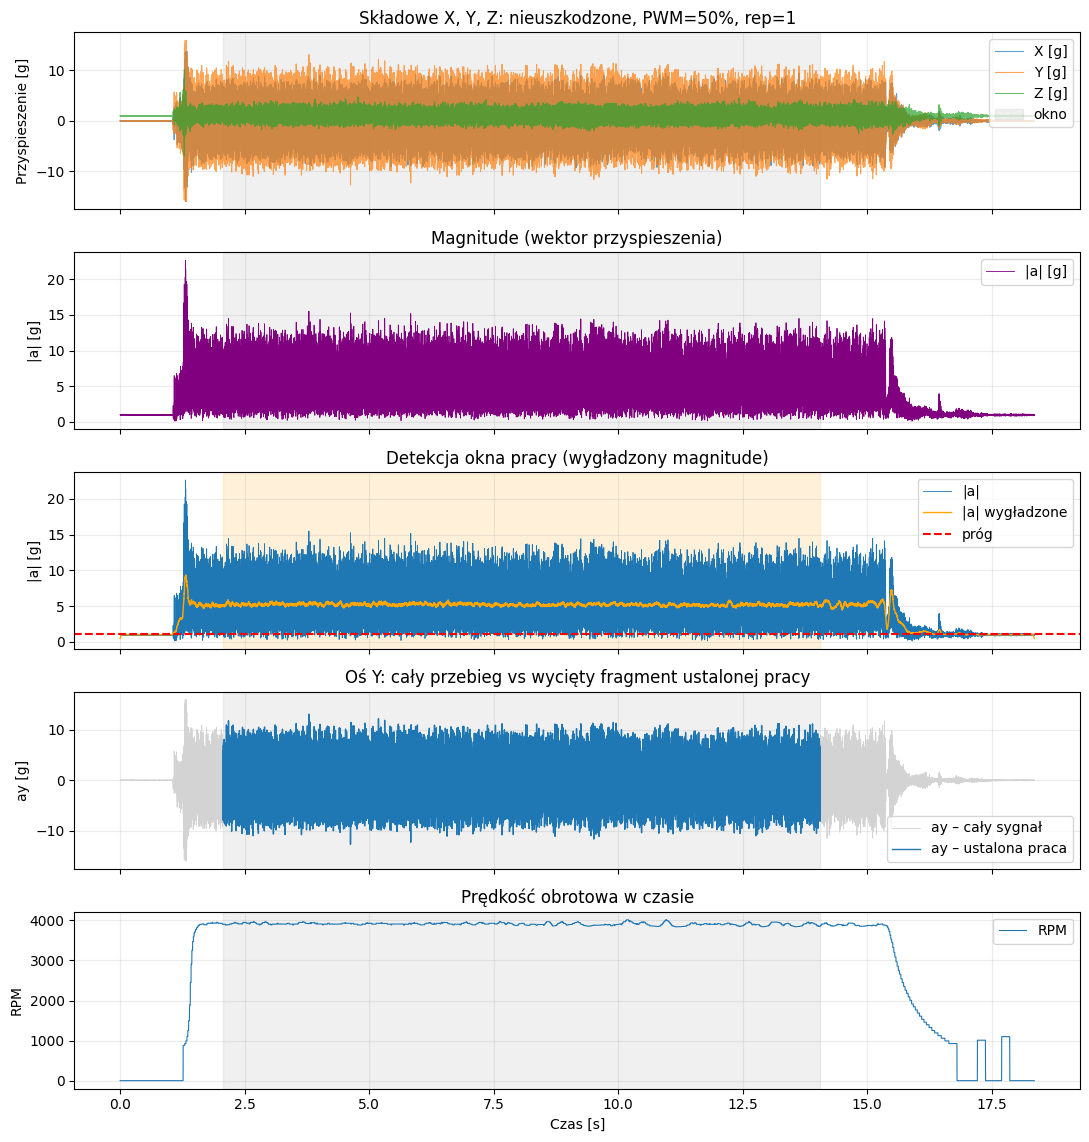

In [57]:
# Komórka 1A - Podgląd przykładowego sygnału w jednej figurze

import matplotlib.pyplot as plt
import numpy as np

# przykładowy plik (możesz zmienić PWM / rep niżej)
example_row = files_df[
    (files_df["condition"] == "nieuszkodzone") &
    (files_df["pwm"] == 50) &
    (files_df["rep"] == 1)
].iloc[0]

example_path = example_row["path"]
print("Przykładowy plik:", example_path)

t, ax_sig, ay_sig, az_sig, Fs, rpm = load_xyz_from_csv(example_path, return_rpm=True)

t_seg, ax_seg, ay_seg, az_seg, (t_start, t_end), mag, mag_smooth, thresh = \
    detect_steady_window(t, ax_sig, ay_sig, az_sig)

print(f"Okno ustalonej pracy: {t_start:.2f}–{t_end:.2f} s, liczba próbek: {len(t_seg)}")

n_rows = 5 if rpm is not None else 4
fig, axes = plt.subplots(n_rows, 1, figsize=(11, 12), sharex=True)

idx = 0

# 1) Składowe X, Y, Z
ax1 = axes[idx]; idx += 1
ax1.plot(t, ax_sig, label="X [g]", lw=0.8, alpha=0.7)
ax1.plot(t, ay_sig, label="Y [g]", lw=0.8, alpha=0.7)
ax1.plot(t, az_sig, label="Z [g]", lw=0.8, alpha=0.7)
ax1.axvspan(t_start, t_end, color="k", alpha=0.06, label="okno")
ax1.set_ylabel("Przyspieszenie [g]")
ax1.set_title(f"Składowe X, Y, Z: {example_row['condition']}, PWM={example_row['pwm']}%, rep={example_row['rep']}")
ax1.grid(alpha=0.25)
ax1.legend()

# 2) Magnitude
ax2 = axes[idx]; idx += 1
ax2.plot(t, mag, color="purple", lw=0.6, label="|a| [g]")
ax2.axvspan(t_start, t_end, color="k", alpha=0.06)
ax2.set_ylabel("|a| [g]")
ax2.set_title("Magnitude (wektor przyspieszenia)")
ax2.grid(alpha=0.25)
ax2.legend()

# 3) Detekcja okna pracy
ax3 = axes[idx]; idx += 1
ax3.plot(t, mag, label="|a|", lw=0.6)
ax3.plot(t, mag_smooth, label="|a| wygładzone", lw=1.0, color="orange")
ax3.axhline(thresh, color="r", ls="--", label="próg")
ax3.axvspan(t_start, t_end, color="orange", alpha=0.15)
ax3.set_ylabel("|a| [g]")
ax3.set_title("Detekcja okna pracy (wygładzony magnitude)")
ax3.grid(alpha=0.25)
ax3.legend()

# 4) Oś Y – cały przebieg vs wycięty fragment
ax4 = axes[idx]; idx += 1
ax4.plot(t, ay_sig, color="lightgray", lw=0.6, label="ay – cały sygnał")
ax4.plot(t_seg, ay_seg, color="C0", lw=1.0, label="ay – ustalona praca")
ax4.axvspan(t_start, t_end, color="k", alpha=0.06)
ax4.set_ylabel("ay [g]")
ax4.set_title("Oś Y: cały przebieg vs wycięty fragment ustalonej pracy")
ax4.grid(alpha=0.25)
ax4.legend()

# 5) RPM (jeśli dostępne)
if rpm is not None:
    ax5 = axes[idx]
    ax5.plot(t, rpm, lw=0.8, label="RPM")
    ax5.axvspan(t_start, t_end, color="k", alpha=0.06)
    ax5.set_xlabel("Czas [s]")
    ax5.set_ylabel("RPM")
    ax5.set_title("Prędkość obrotowa w czasie")
    ax5.grid(alpha=0.25)
    ax5.legend()
else:
    axes[-1].set_xlabel("Czas [s]")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


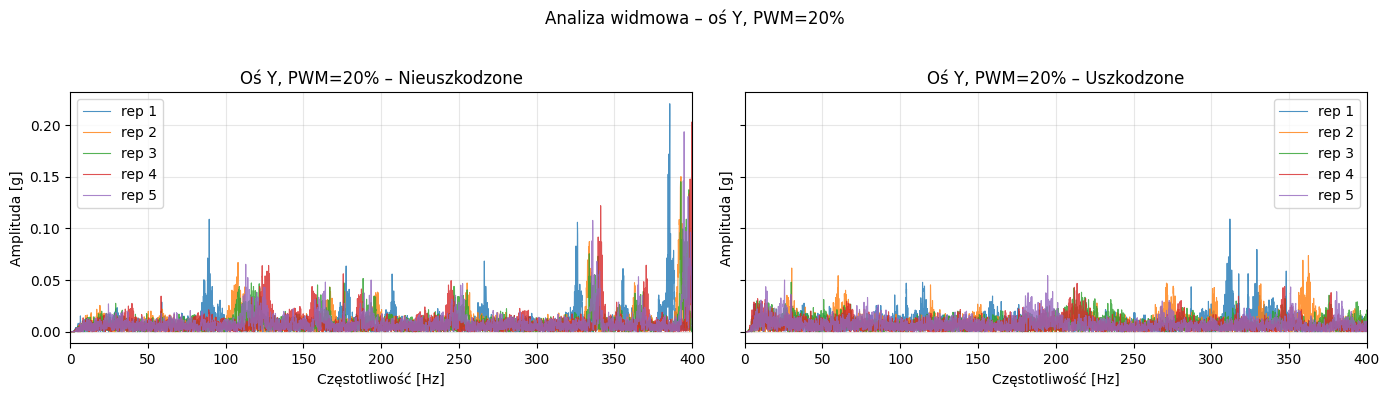

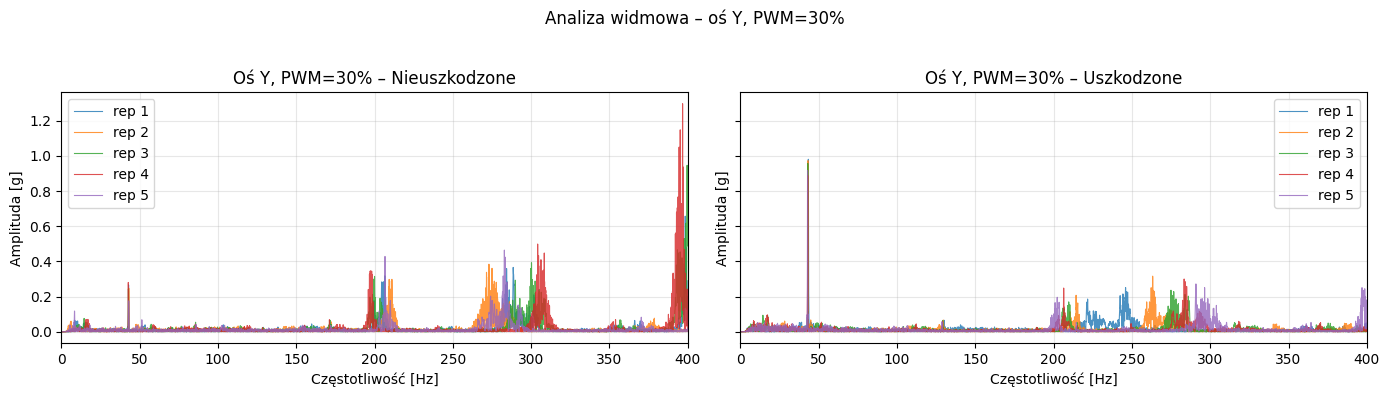

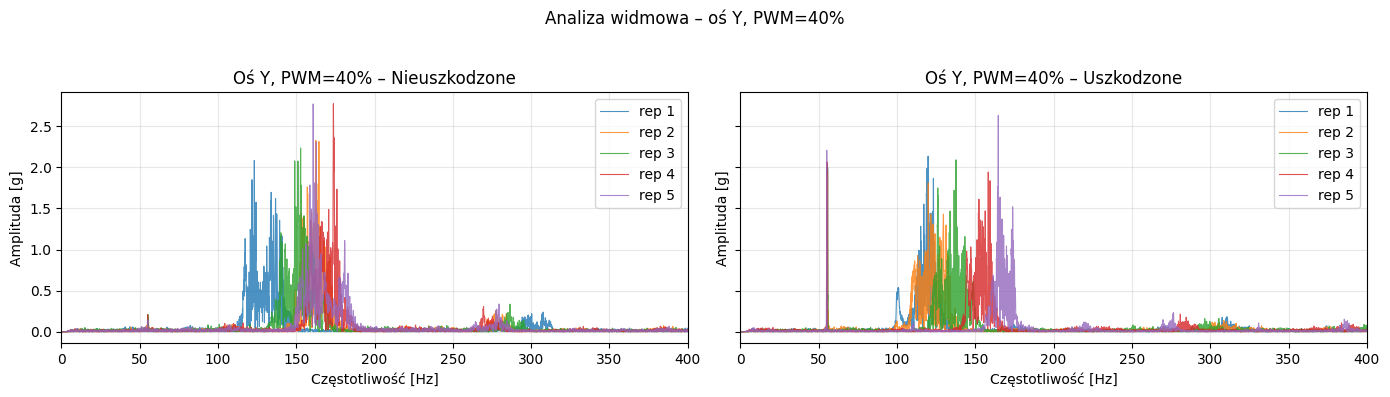

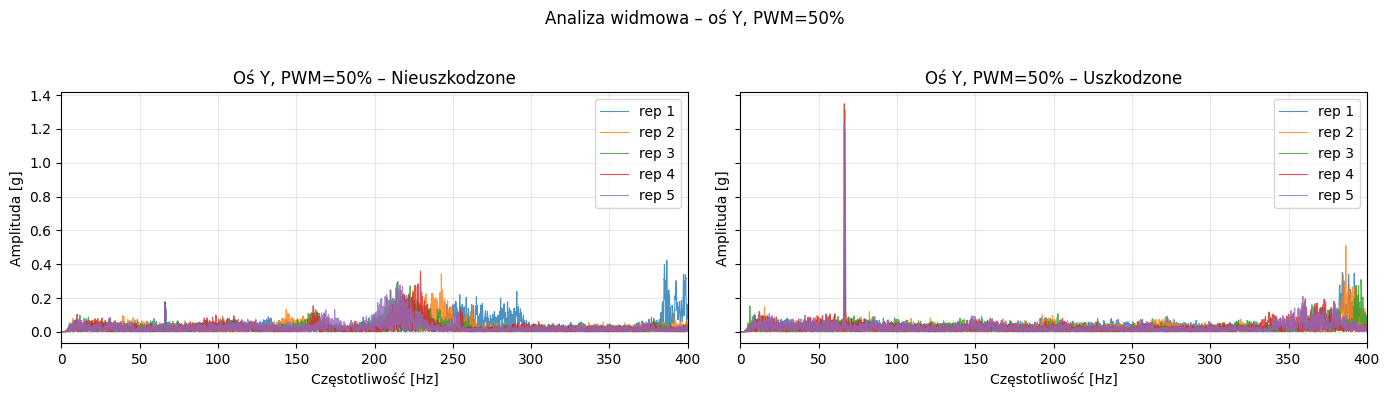

In [49]:
# Komórka 2 - Porównanie widm sygnałów Y (amplituda, bez dB)

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

plt.rcParams["figure.figsize"] = (10, 4)

pwm_values = [20, 30, 40, 50]
fmax_plot = 400.0
hp_cut_hz = 5.0
n_fft_pad_factor = 8

def compute_fft_amp(y, Fs, hp_cut=5.0, pad_factor=8):
    """FFT z filtrem HP i oknem Hann – zwraca (freqs, amp) w [g]."""
    # usunięcie składowej stałej z kawałka sygnału
    N0 = int(min(len(y), 2 * Fs))
    y0 = y - np.mean(y[:N0])

    # filtr górnoprzepustowy
    if hp_cut is not None and hp_cut > 0:
        b, a = signal.butter(2, hp_cut / (Fs / 2), btype="highpass")
        y_hp = signal.filtfilt(b, a, y0)
    else:
        y_hp = y0

    # okno Hann
    w = signal.windows.hann(len(y_hp), sym=False)
    CG = np.sum(w) / len(w)
    yw = y_hp * w

    N = len(yw)
    N_fft = int(2 ** np.ceil(np.log2(N))) * pad_factor

    X = np.fft.rfft(yw, n=N_fft)
    freqs = np.fft.rfftfreq(N_fft, 1.0 / Fs)

    amp = (2.0 / (N * CG)) * np.abs(X)
    if len(amp) > 0:
        amp[0] /= 2.0

    return freqs, amp


for pwm in pwm_values:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
    fig.suptitle(f"Analiza widmowa – oś Y, PWM={pwm}%", y=0.98)

    for ax, cond, title_cond in zip(
        axes,
        ["nieuszkodzone", "uszkodzone"],
        ["Nieuszkodzone", "Uszkodzone"]
    ):
        sel = files_df[
            (files_df["condition"] == cond) &
            (files_df["pwm"] == pwm)
        ].sort_values("rep")

        if sel.empty:
            ax.text(0.5, 0.5, "Brak danych", ha="center", va="center")
            ax.set_xlim(0, fmax_plot)
            ax.set_xlabel("Częstotliwość [Hz]")
            ax.set_ylabel("Amplituda [g]")
            ax.grid(alpha=0.3)
            ax.set_title(f"Oś Y, PWM={pwm}% – {title_cond}")
            continue

        for _, row in sel.iterrows():
            path = row["path"]
            rep  = row["rep"]

            t, ax_sig, ay_sig, az_sig, Fs = load_xyz_from_csv(path)
            t_seg, ax_seg, ay_seg, az_seg, (t_start, t_end), mag, mag_smooth, thresh = \
                detect_steady_window(t, ax_sig, ay_sig, az_sig)

            freqs, amp = compute_fft_amp(ay_seg, Fs, hp_cut=hp_cut_hz,
                                         pad_factor=n_fft_pad_factor)
            mask = freqs <= fmax_plot
            ax.plot(freqs[mask], amp[mask], lw=0.8, alpha=0.8, label=f"rep {rep}")

        ax.set_xlim(0, fmax_plot)
        ax.set_xlabel("Częstotliwość [Hz]")
        ax.set_ylabel("Amplituda [g]")
        ax.set_title(f"Oś Y, PWM={pwm}% – {title_cond}")
        ax.grid(alpha=0.3)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


C:\Users\szymo\AppData\Local\Temp\ipykernel_2508\1271296433.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 0.97])


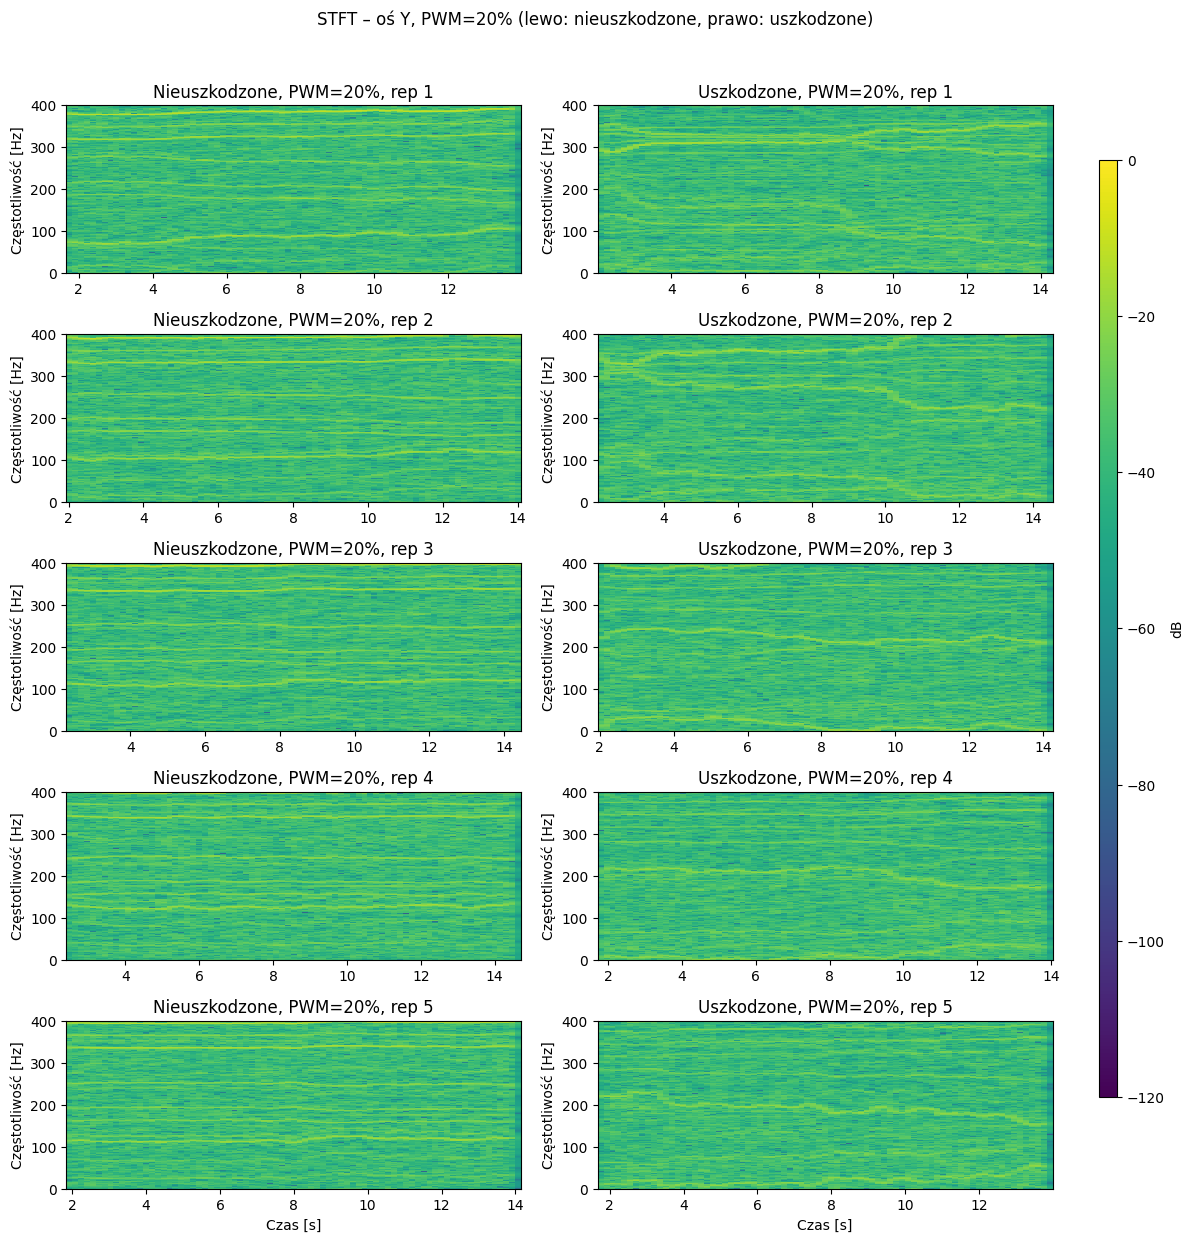

C:\Users\szymo\AppData\Local\Temp\ipykernel_2508\1271296433.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 0.97])


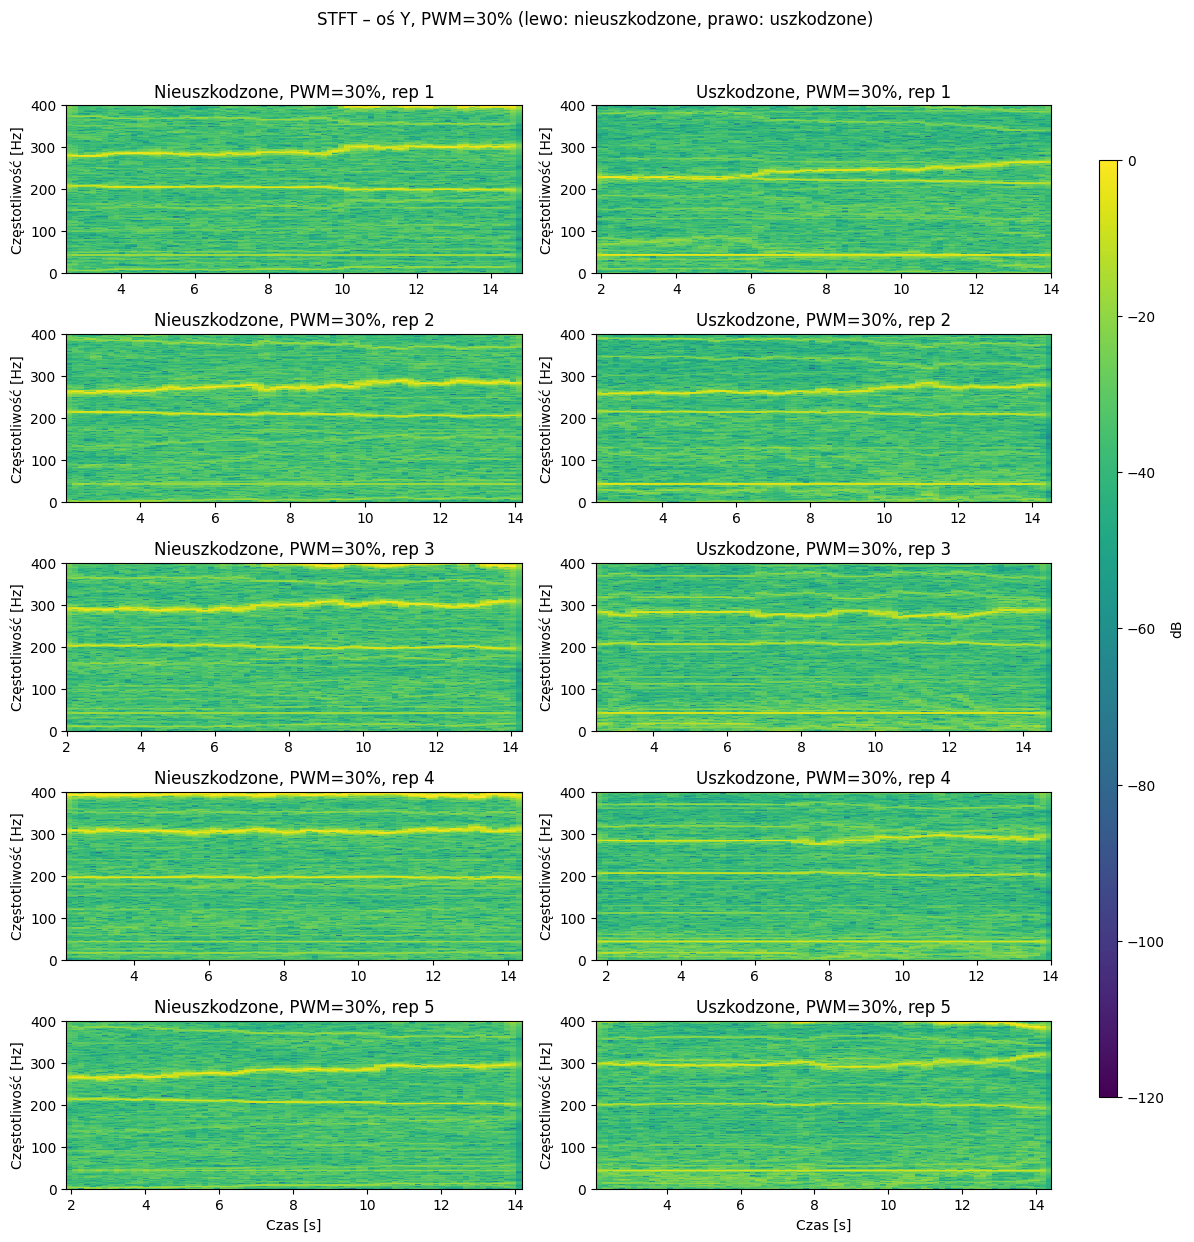

C:\Users\szymo\AppData\Local\Temp\ipykernel_2508\1271296433.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 0.97])


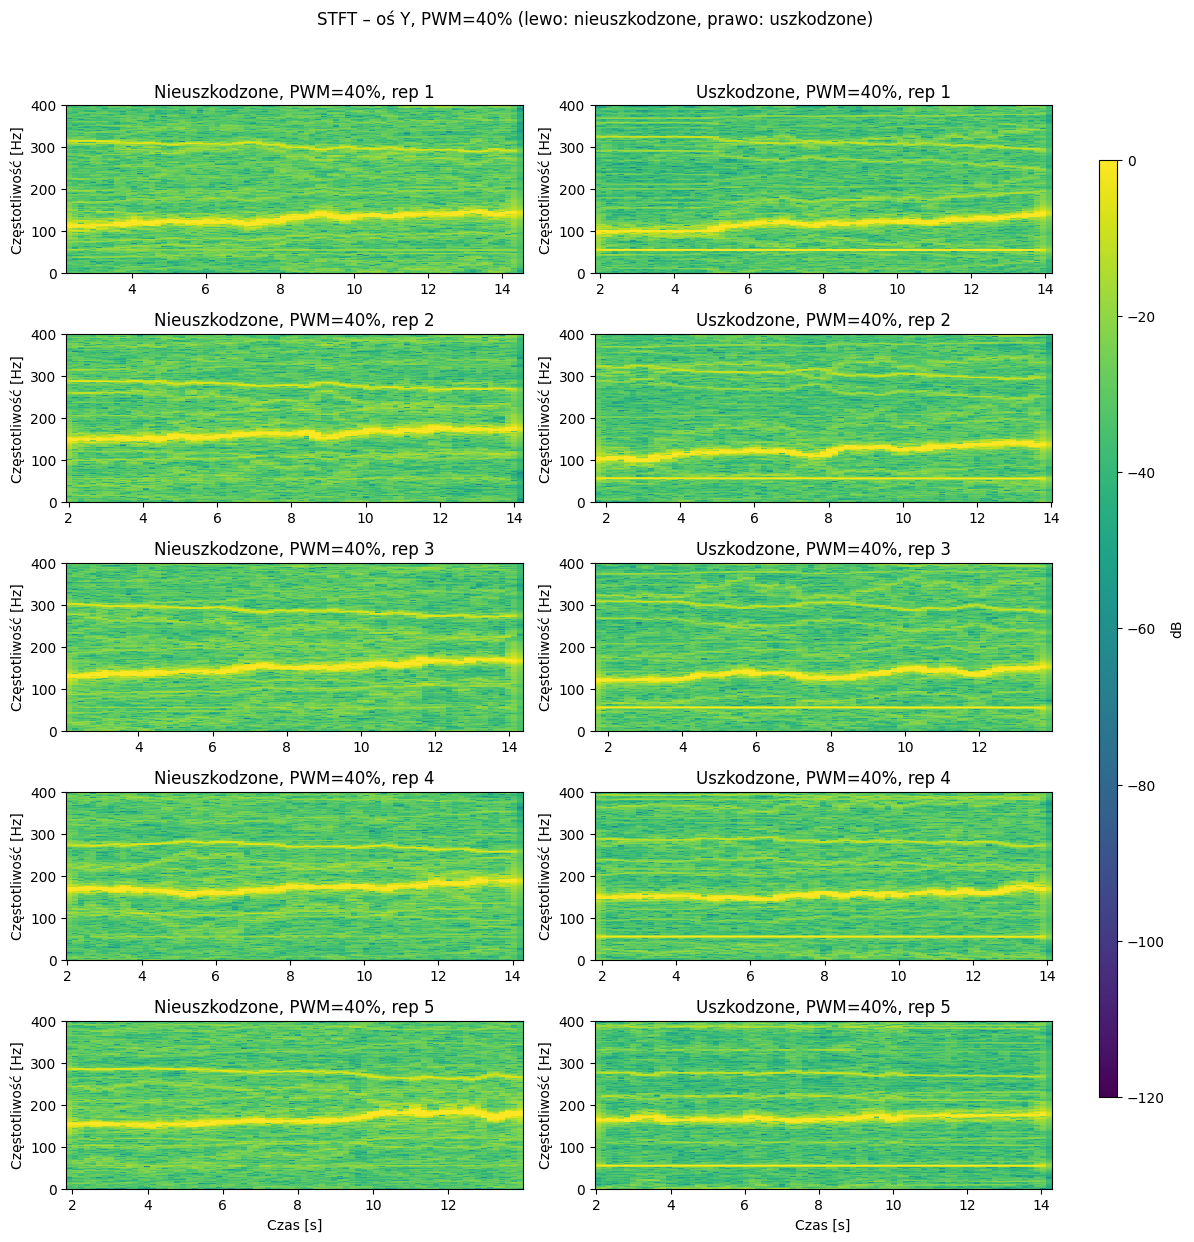

C:\Users\szymo\AppData\Local\Temp\ipykernel_2508\1271296433.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 0.97])


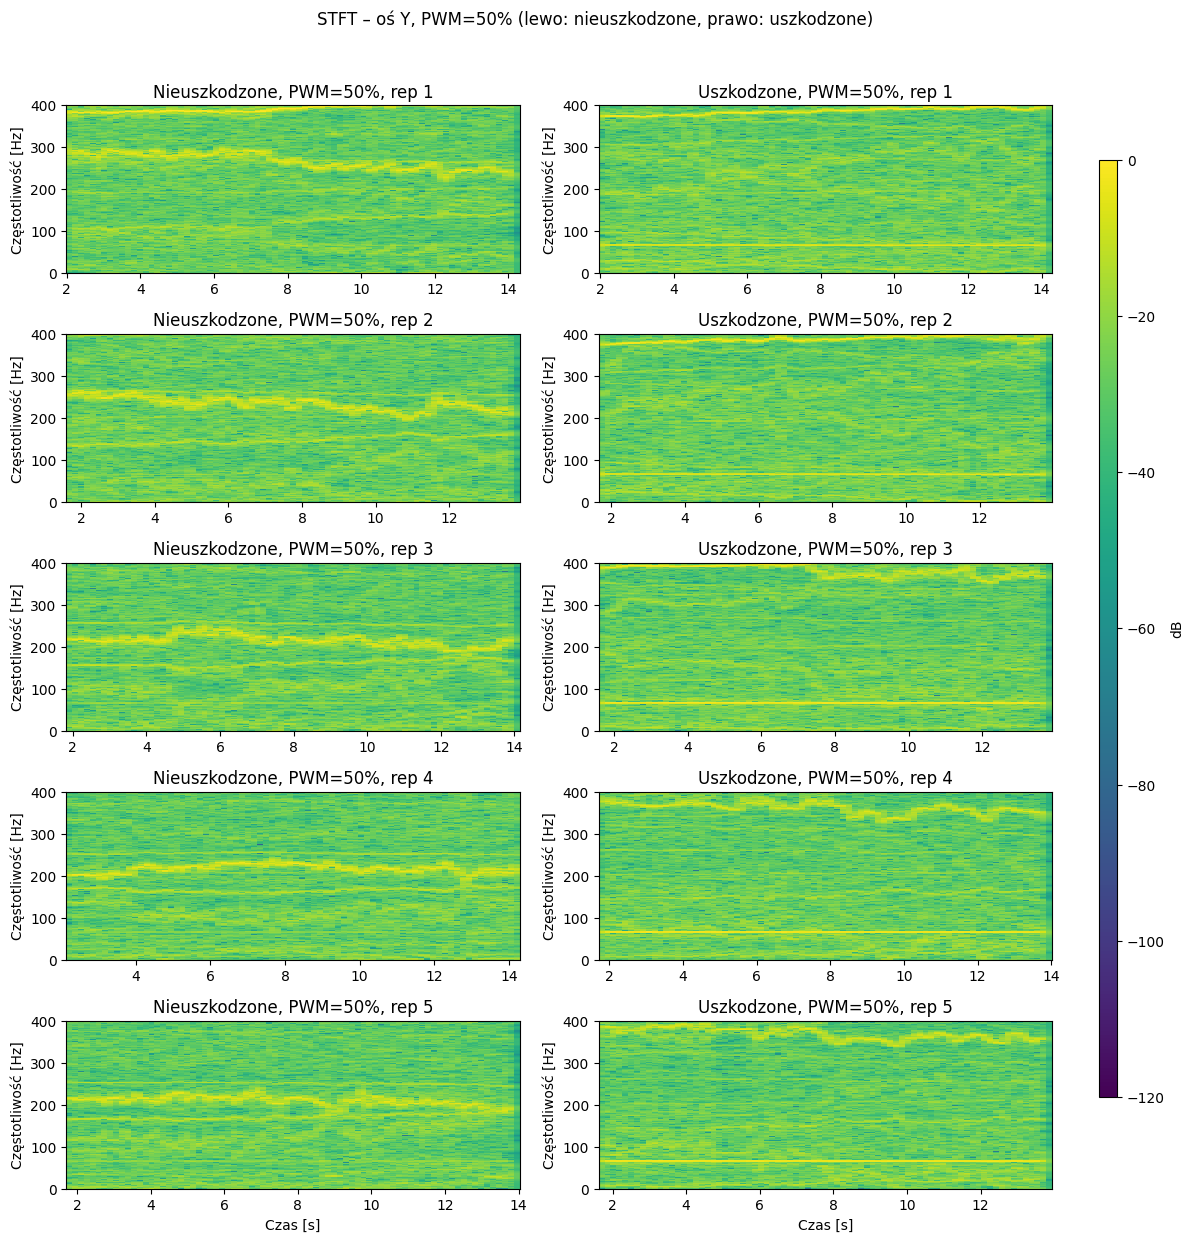

In [7]:
# Komórka 3 - Porównanie STFT dla dwóch stanów śmigła przy danym PWM
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

plt.rcParams["figure.figsize"] = (12, 4)

pwm_values = [20, 30, 40, 50]

# --- RĘCZNIE USTAWIANA POZYCJA COLORBARA (MOŻESZ TO ZMIENIAĆ) ---
CBAR_LEFT   = 0.92   # pozycja w osi X (0–1)
CBAR_BOTTOM = 0.12   # pozycja w osi Y (0–1)
CBAR_WIDTH  = 0.015  # szerokość
CBAR_HEIGHT = 0.75   # wysokość
# ---------------------------------------------------------------

for pwm in pwm_values:
    ok_df = files_df[
        (files_df["condition"] == "nieuszkodzone") &
        (files_df["pwm"] == pwm)
    ].sort_values("rep")

    dmg_df = files_df[
        (files_df["condition"] == "uszkodzone") &
        (files_df["pwm"] == pwm)
    ].sort_values("rep")

    if ok_df.empty or dmg_df.empty:
        print(f"Brak kompletu danych dla PWM={pwm}%")
        continue

    common_reps = sorted(set(ok_df["rep"].dropna()) & set(dmg_df["rep"].dropna()))
    if not common_reps:
        print(f"Brak wspólnych rep dla PWM={pwm}%")
        continue

    n_reps = len(common_reps)

    fig, axes = plt.subplots(
        n_reps, 2,
        figsize=(12, 2.5 * n_reps),
        squeeze=False
    )

    last_im = None

    for row_idx, rep in enumerate(common_reps):
        # NIEUSZKODZONE
        row_ok = ok_df[ok_df["rep"] == rep].iloc[0]
        path_ok = row_ok["path"]
        t_ok, ax_ok, ay_ok, az_ok, Fs_ok = load_xyz_from_csv(path_ok)
        t_seg_ok, ax_seg_ok, ay_seg_ok, az_seg_ok, (t_start_ok, t_end_ok), mag_ok, mag_smooth_ok, thresh_ok = \
            detect_steady_window(t_ok, ax_ok, ay_ok, az_ok)

        y_ok = ay_seg_ok - ay_seg_ok.mean()
        f_ok, tt_ok, Z_ok = stft(
            y_ok, fs=Fs_ok,
            window="hann",
            nperseg=1024,
            noverlap=768
        )
        Zok_db = 20 * np.log10(np.abs(Z_ok) + 1e-12)

        ax_left = axes[row_idx, 0]
        im = ax_left.pcolormesh(
            tt_ok + t_seg_ok[0], f_ok, Zok_db,
            shading="auto", vmin=-120, vmax=0
        )
        last_im = im
        ax_left.set_ylim(0, 400)
        if row_idx == n_reps - 1:
            ax_left.set_xlabel("Czas [s]")
        ax_left.set_ylabel("Częstotliwość [Hz]")
        ax_left.set_title(f"Nieuszkodzone, PWM={pwm}%, rep {rep}")

        # USZKODZONE
        row_dmg = dmg_df[dmg_df["rep"] == rep].iloc[0]
        path_dmg = row_dmg["path"]
        t_d, ax_d, ay_d, az_d, Fs_d = load_xyz_from_csv(path_dmg)
        t_seg_d, ax_seg_d, ay_seg_d, az_seg_d, (t_start_d, t_end_d), mag_d, mag_smooth_d, thresh_d = \
            detect_steady_window(t_d, ax_d, ay_d, az_d)

        y_d = ay_seg_d - ay_seg_d.mean()
        f_d, tt_d, Z_d = stft(
            y_d, fs=Fs_d,
            window="hann",
            nperseg=1024,
            noverlap=768
        )
        Zd_db = 20 * np.log10(np.abs(Z_d) + 1e-12)

        ax_right = axes[row_idx, 1]
        im = ax_right.pcolormesh(
            tt_d + t_seg_d[0], f_d, Zd_db,
            shading="auto", vmin=-120, vmax=0
        )
        last_im = im
        ax_right.set_ylim(0, 400)
        if row_idx == n_reps - 1:
            ax_right.set_xlabel("Czas [s]")
        ax_right.set_ylabel("Częstotliwość [Hz]")
        ax_right.set_title(f"Uszkodzone, PWM={pwm}%, rep {rep}")

    # colorbar w osobnej osi poza wykresami
    if last_im is not None:
        cbar_ax = fig.add_axes([CBAR_LEFT, CBAR_BOTTOM, CBAR_WIDTH, CBAR_HEIGHT])
        cbar = fig.colorbar(last_im, cax=cbar_ax)
        cbar.set_label("dB")

    fig.suptitle(
        f"STFT – oś Y, PWM={pwm}% (lewo: nieuszkodzone, prawo: uszkodzone)",
        y=0.99
    )
    # zostawiamy miejsce na colorbar po prawej -> rect[2] < 1
    fig.tight_layout(rect=[0, 0, 0.9, 0.97])
    plt.show()


In [8]:
# Komórka 4 - Liczenie parametrów CWT (funkcja + struktura do wizualizacji)
import numpy as np
import pywt

def compute_cwt_freq_y(y, Fs, fmin=0.5, fmax=400, n_freqs=256,
                       wavelet="cmor3.5-1.0", normalize=True):
    y = y - y.mean()
    if normalize:
        rms = np.sqrt((y**2).mean())
        if rms > 0:
            y = y / rms

    dt = 1.0 / Fs
    freqs = np.linspace(fmin, fmax, n_freqs)
    scales = pywt.frequency2scale(wavelet, freqs * dt)

    coeffs, _ = pywt.cwt(y, scales, wavelet, sampling_period=dt)
    power = np.abs(coeffs)
    power_db = 20 * np.log10(power + 1e-12)
    return freqs, power_db


conditions = ["nieuszkodzone", "uszkodzone"]
pwm_values = [20, 30, 40, 50]

cwt_Y = {cond: {p: [] for p in pwm_values} for cond in conditions}

for cond in conditions:
    for pwm in pwm_values:
        subset = files_df[
            (files_df["condition"] == cond) &
            (files_df["pwm"] == pwm) &
            (files_df["rep"] <= 4)      # tylko rep 1–4 (trening / analiza)
        ].sort_values("rep")

        if subset.empty:
            print(f"Brak plików dla {cond}, PWM={pwm}% (rep 1–4)")
            continue

        for _, row in subset.iterrows():
            path = row["path"]
            t, ax, ay, az, Fs = load_xyz_from_csv(path)
            t_seg, ax_seg, ay_seg, az_seg, (t_start, t_end), mag, mag_smooth, thresh = \
                detect_steady_window(t, ax, ay, az)

            y_seg = ay_seg

            freqs, power_db = compute_cwt_freq_y(
                y_seg, Fs,
                fmin=0.5,
                fmax=400,
                n_freqs=256
            )

            cwt_Y[cond][pwm].append({
                "meta": row,
                "Fs": Fs,
                "t": t_seg,
                "y": y_seg,
                "freqs": freqs,
                "power_db": power_db,
                "t_start": t_start,
                "t_end": t_end,
            })

print("Gotowe: policzono CWT dla osi Y (stany śmigła, PWM, rep 1–4).")


Gotowe: policzono CWT dla osi Y (stany śmigła, PWM, rep 1–4).


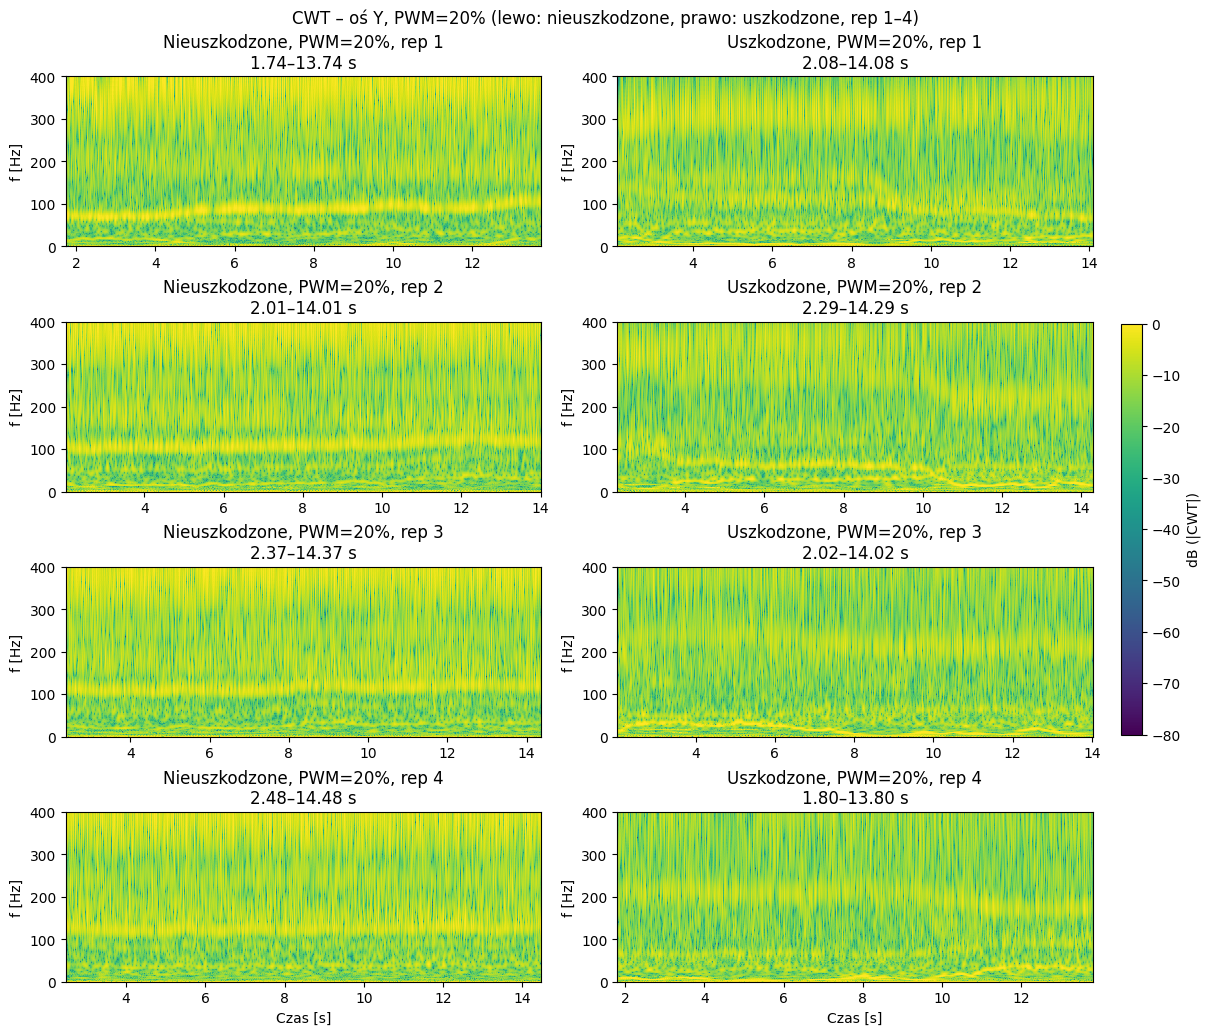

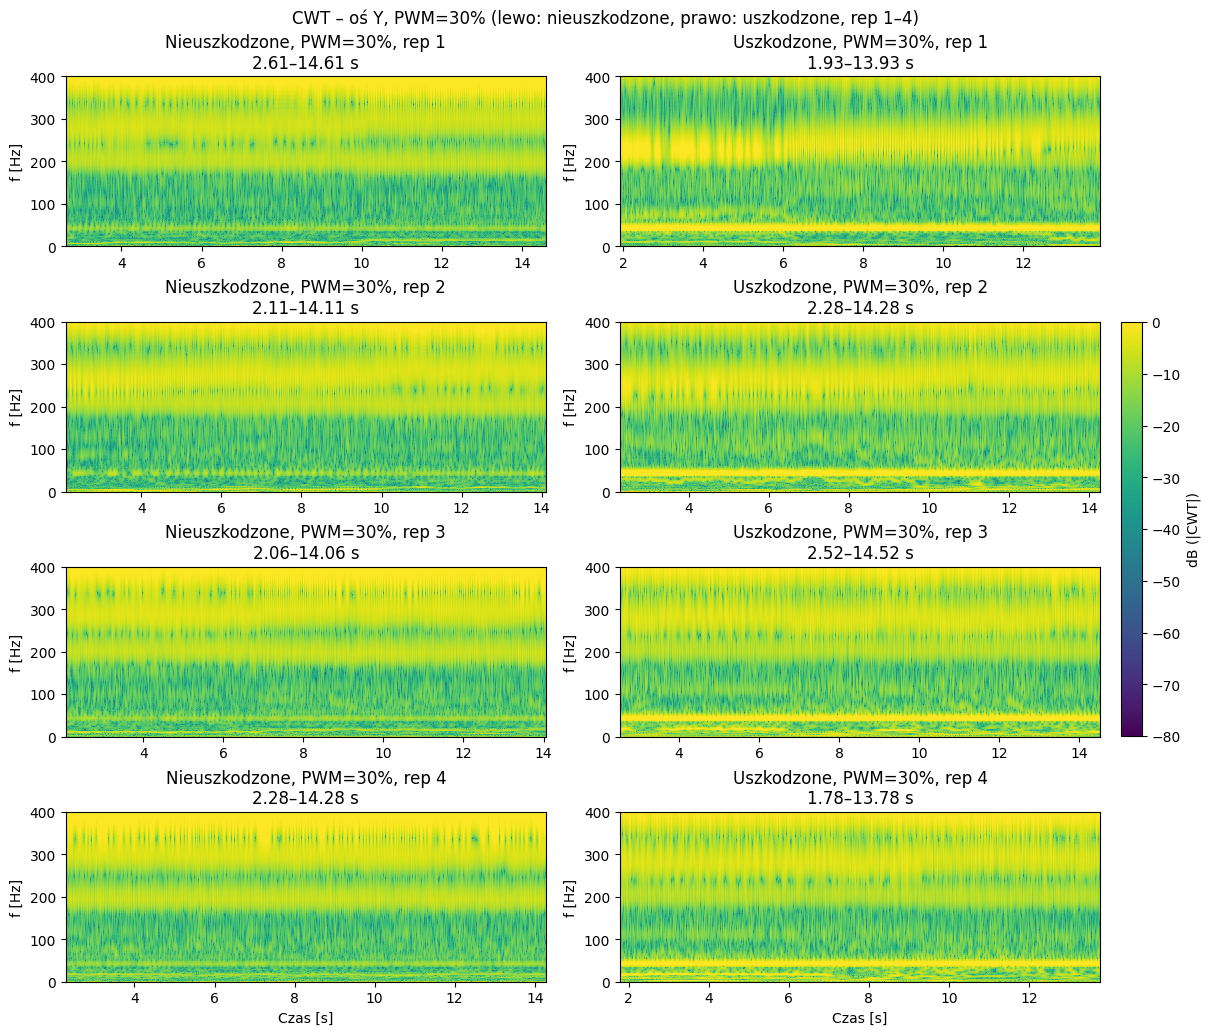

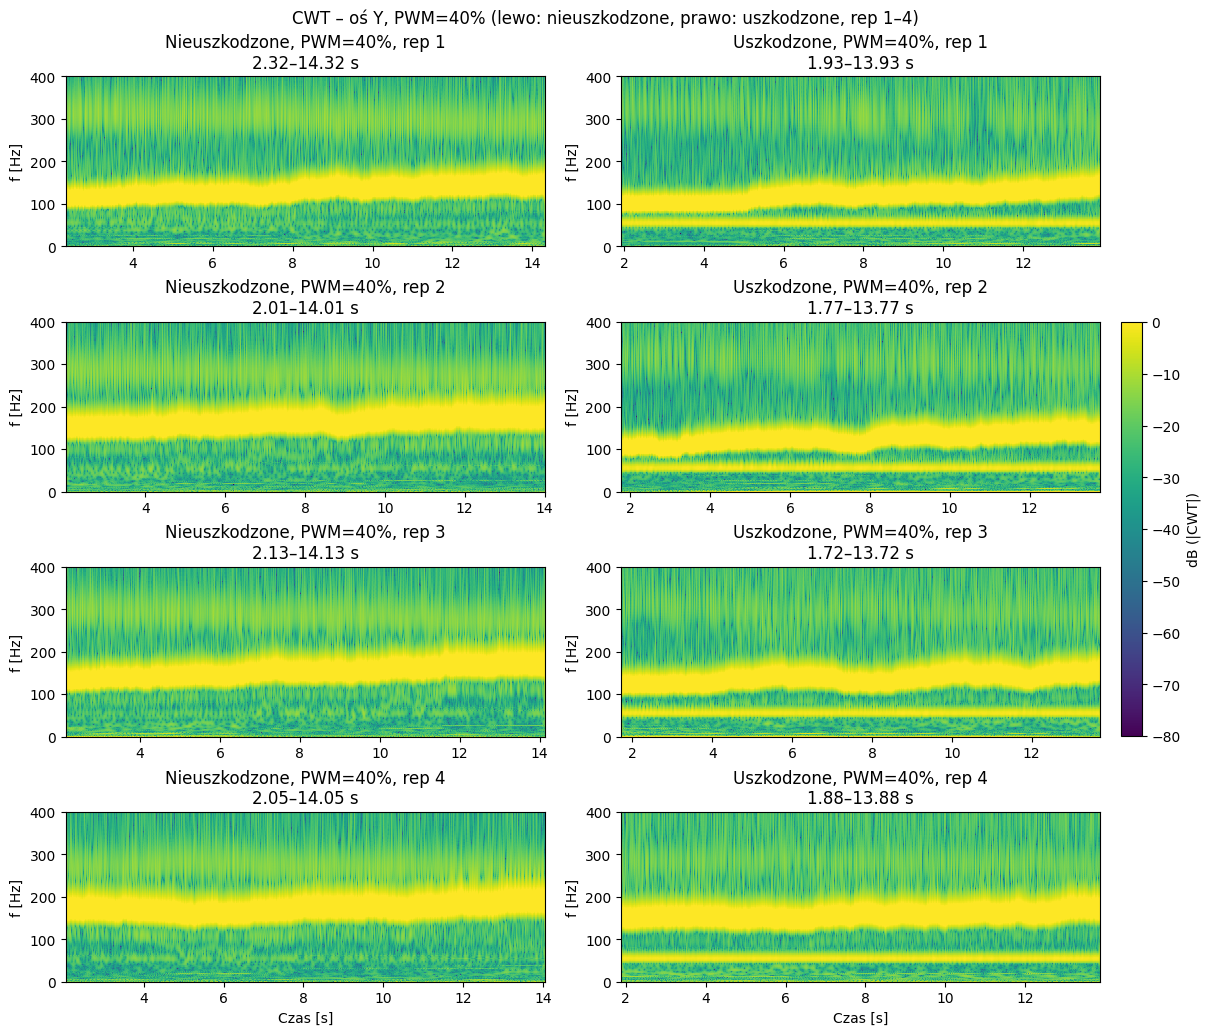

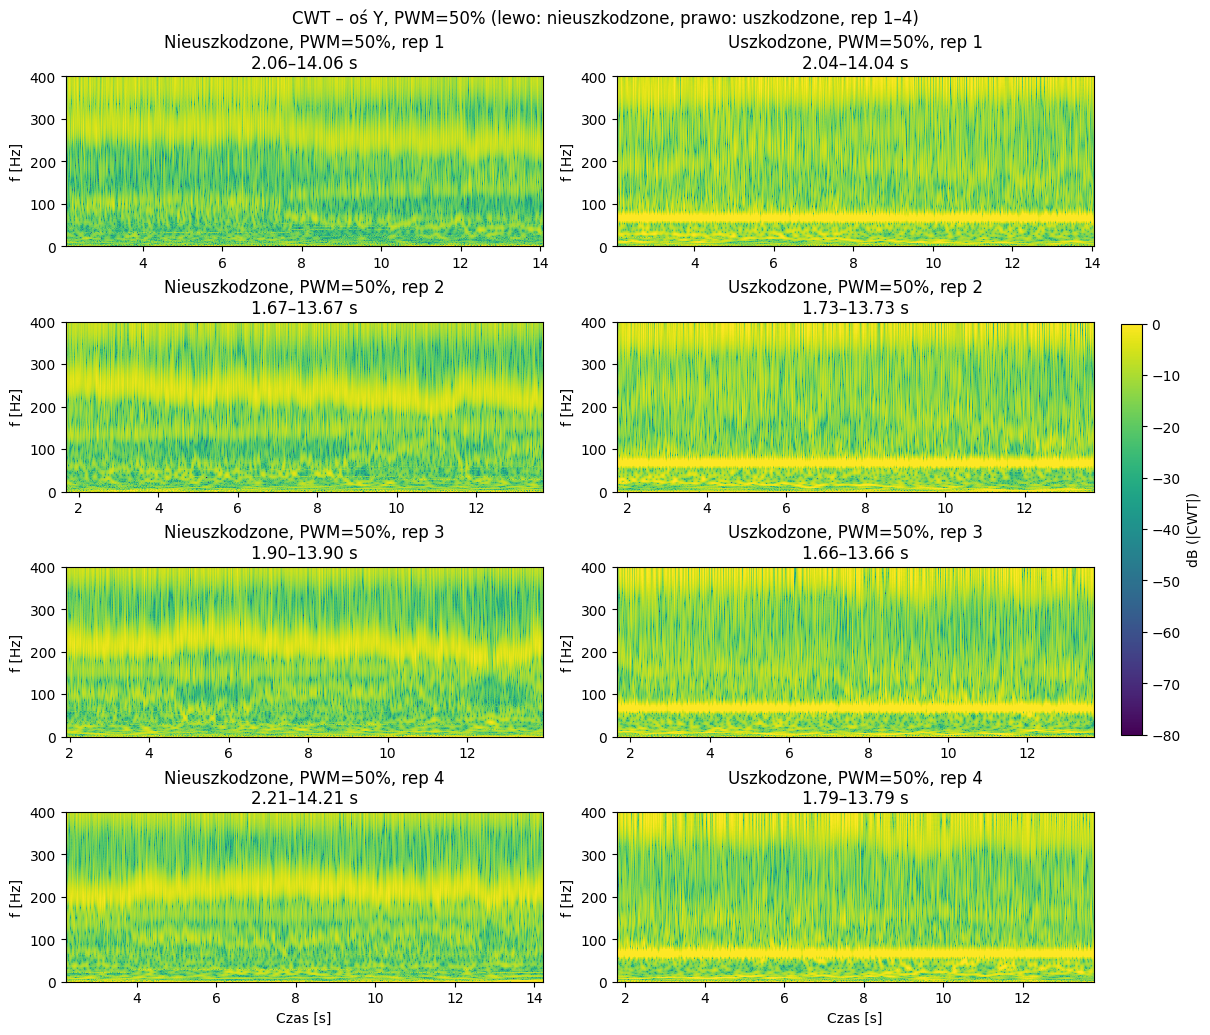

In [9]:
# Komórka 5 - Porównanie wykresów CWT dla danego PWM:
import numpy as np
import matplotlib.pyplot as plt

vmin, vmax = -80, 0  # zakres dB do skalogramów

for pwm in pwm_values:
    segs_ok  = cwt_Y["nieuszkodzone"][pwm]
    segs_dmg = cwt_Y["uszkodzone"][pwm]

    if len(segs_ok) == 0 or len(segs_dmg) == 0:
        print(f"Brak CWT dla PWM={pwm}%")
        continue

    # mapowanie rep -> segment
    dict_ok  = {seg["meta"]["rep"]: seg for seg in segs_ok}
    dict_dmg = {seg["meta"]["rep"]: seg for seg in segs_dmg}

    common_reps = sorted(set(dict_ok.keys()) & set(dict_dmg.keys()))
    if not common_reps:
        print(f"Brak wspólnych rep w CWT dla PWM={pwm}%")
        continue

    n_reps = len(common_reps)

    fig, axes = plt.subplots(
        n_reps, 2,
        figsize=(12, 2.5 * n_reps),
        squeeze=False,
        constrained_layout=True
    )

    last_im = None

    for row_idx, rep in enumerate(common_reps):
        seg_ok = dict_ok[rep]
        seg_d  = dict_dmg[rep]

        # NIEUSZKODZONE
        ax_left = axes[row_idx, 0]
        t_ok = seg_ok["t"]
        freqs_ok = seg_ok["freqs"]
        P_db_ok = np.clip(seg_ok["power_db"], vmin, vmax)
        t_start_ok = seg_ok["t_start"]
        t_end_ok   = seg_ok["t_end"]

        im = ax_left.pcolormesh(
            t_ok, freqs_ok, P_db_ok,
            shading="auto", vmin=vmin, vmax=vmax
        )
        last_im = im
        ax_left.set_ylim(0, 400)
        ax_left.set_ylabel("f [Hz]")
        if row_idx == n_reps - 1:
            ax_left.set_xlabel("Czas [s]")
        ax_left.set_title(
            f"Nieuszkodzone, PWM={pwm}%, rep {rep}\n"
            f"{t_start_ok:.2f}–{t_end_ok:.2f} s"
        )

        # USZKODZONE
        ax_right = axes[row_idx, 1]
        t_d = seg_d["t"]
        freqs_d = seg_d["freqs"]
        P_db_d = np.clip(seg_d["power_db"], vmin, vmax)
        t_start_d = seg_d["t_start"]
        t_end_d   = seg_d["t_end"]

        im = ax_right.pcolormesh(
            t_d, freqs_d, P_db_d,
            shading="auto", vmin=vmin, vmax=vmax
        )
        last_im = im
        ax_right.set_ylim(0, 400)
        if row_idx == n_reps - 1:
            ax_right.set_xlabel("Czas [s]")
        ax_right.set_ylabel("f [Hz]")
        ax_right.set_title(
            f"Uszkodzone, PWM={pwm}%, rep {rep}\n"
            f"{t_start_d:.2f}–{t_end_d:.2f} s"
        )

    if last_im is not None:
        fig.colorbar(
            last_im,
            ax=axes[:, 0].tolist() + axes[:, 1].tolist(),
            label="dB (|CWT|)",
            fraction=0.02,
            pad=0.02
        )

    fig.suptitle(
        f"CWT – oś Y, PWM={pwm}% (lewo: nieuszkodzone, prawo: uszkodzone, rep 1–4)",
        y=1.02
    )
    plt.show()


In [35]:
# Komórka 6 - CWT + cechy obrotowe z FFT
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy import signal

# pasma do cech CWT
bands = [
    (0.5, 40),
    (40, 100),
    (100, 200),
    (200, 400),
]

def extract_features_from_cwt(freqs, power_db, bands):
    feats = {}

    # uśrednione widmo (po czasie)
    mean_spec = power_db.mean(axis=1)

    # cechy pasmowe
    for (f1, f2) in bands:
        mask = (freqs >= f1) & (freqs <= f2)
        label = f"{int(f1)}_{int(f2)}"
        if not np.any(mask):
            feats[f"E_{label}"]    = np.nan
            feats[f"Var_{label}"]  = np.nan
            feats[f"Kurt_{label}"] = np.nan
            continue

        band_mat = power_db[mask, :]          # (n_band_freq, n_time)
        band_time = band_mat.mean(axis=0)     # seria w czasie (n_time,)

        feats[f"E_{label}"]    = band_time.mean()
        feats[f"Var_{label}"]  = band_time.var()
        feats[f"Kurt_{label}"] = kurtosis(band_time, fisher=False, bias=False)

    # cechy globalne: centroid, mean, std
    weights = 10 ** (mean_spec / 20.0)
    w_sum = weights.sum()
    if w_sum > 0:
        centroid = (freqs * weights).sum() / w_sum
    else:
        centroid = np.nan

    feats["centroid_hz"] = centroid
    feats["mean_db"]     = mean_spec.mean()
    feats["std_db"]      = mean_spec.std()

    # spectral flatness i rolloff
    P_lin = 10 ** (mean_spec / 10.0)
    P_lin[P_lin <= 0] = 1e-12

    gm = np.exp(np.log(P_lin).mean())
    am = P_lin.mean()
    feats["spec_flatness"] = gm / am if am > 0 else np.nan

    # rolloff 95%
    cumsum = np.cumsum(P_lin)
    thr = 0.95 * cumsum[-1]
    idx = np.searchsorted(cumsum, thr)
    if idx >= len(freqs):
        idx = len(freqs) - 1
    feats["rolloff_hz"] = freqs[idx]

    return feats


def extract_rot_features_from_fft(y, Fs, f_rot, fmax_search=200.0):
    """Cechy związane z linią prędkości obrotowej."""
    feats = {
        "A_rot": np.nan,
        "A_2rot": np.nan,
        "A_rot_HF_ratio": np.nan,
    }
    if f_rot is None or np.isnan(f_rot):
        return feats

    freqs, amp = compute_fft_amp(y, Fs, hp_cut=5.0, pad_factor=8)

    def max_in_band(center, width=2.0):
        mask = (freqs >= center - width) & (freqs <= center + width)
        if not np.any(mask):
            return np.nan
        return amp[mask].max()

    # pik przy f_rot i 2*f_rot (o ile w zakresie wyszukiwania)
    A1 = max_in_band(f_rot, width=2.0)
    A2 = max_in_band(2 * f_rot, width=2.0) if 2 * f_rot <= fmax_search else np.nan

    # średnia amplituda "tła" w wyższych częstotliwościach
    HF_mask = (freqs >= 200.0) & (freqs <= 400.0)
    HF_mean = np.nan
    if np.any(HF_mask):
        HF_mean = amp[HF_mask].mean()

    if not np.isnan(A1) and not np.isnan(HF_mean) and HF_mean > 0:
        ratio = A1 / HF_mean
    else:
        ratio = np.nan

    feats["A_rot"] = A1
    feats["A_2rot"] = A2
    feats["A_rot_HF_ratio"] = ratio

    return feats


rows = []

# bierzemy tylko rep 1–4 (trening)
train_subset = files_df[files_df["rep"] <= 4].sort_values(
    ["condition", "pwm", "rep"]
)

for _, row in train_subset.iterrows():
    path    = row["path"]
    file_id = row["file_id"]
    cond    = row["condition"]
    pwm     = row["pwm"]
    rep     = row["rep"]

    # wczytanie z RPM
    t, ax, ay, az, Fs, rpm = load_xyz_from_csv(path, return_rpm=True)
    t_seg, ax_seg, ay_seg, az_seg, (t_start, t_end), mag, mag_smooth, thresh = \
        detect_steady_window(t, ax, ay, az)

    # maska okna ustalonej pracy do RPM
    mask_seg_full = (t >= t_start) & (t <= t_end)
    f_rot = None
    if rpm is not None:
        rpm_seg = rpm[mask_seg_full]
        if len(rpm_seg) > 0:
            rpm_mean = rpm_seg.mean()
            f_rot = rpm_mean / 60.0  # Hz

    # dzielimy ustaloną pracę na 2 połówki
    N   = len(ay_seg)
    mid = N // 2
    halves = [
        (t_seg[:mid],  ay_seg[:mid]),
        (t_seg[mid:], ay_seg[mid:]),
    ]

    for part_idx, (t_part, y_part) in enumerate(halves):
        # CWT
        freqs, power_db = compute_cwt_freq_y(
            y_part, Fs,
            fmin=0.5,
            fmax=400,
            n_freqs=256
        )

        feat_dict = extract_features_from_cwt(freqs, power_db, bands)

        # cechy obrotowe z FFT
        rot_feats = extract_rot_features_from_fft(y_part, Fs, f_rot)

        row_feat = {
            "file_id": file_id,
            "condition": cond,
            "pwm": pwm,
            "rep": rep,
            "part": part_idx,
        }
        row_feat.update(feat_dict)
        row_feat.update(rot_feats)

        rows.append(row_feat)

features_df = pd.DataFrame(rows)

# cechy stosunkowe HF/LF (jak wcześniej)
if {"E_200_400", "E_0_40"}.issubset(features_df.columns):
    features_df["E_HF_minus_LF"] = features_df["E_200_400"] - features_df["E_0_40"]
else:
    features_df["E_HF_minus_LF"] = np.nan

if {"E_40_100", "E_0_40"}.issubset(features_df.columns):
    features_df["E_MID_minus_LF"] = features_df["E_40_100"] - features_df["E_0_40"]
else:
    features_df["E_MID_minus_LF"] = np.nan

print("Liczba przykładów treningowych (rep 1–4, 2 połówki):", len(features_df))
display(features_df.head())


Liczba przykładów treningowych (rep 1–4, 2 połówki): 64


file_id      condition  pwm  rep  \
0  fabryczne_nieuszkodzone\pwm_20%\1_fabryczne_ni...  nieuszkodzone   20    1   
1  fabryczne_nieuszkodzone\pwm_20%\1_fabryczne_ni...  nieuszkodzone   20    1   
2  fabryczne_nieuszkodzone\pwm_20%\2_fabryczne_ni...  nieuszkodzone   20    2   
3  fabryczne_nieuszkodzone\pwm_20%\2_fabryczne_ni...  nieuszkodzone   20    2   
4  fabryczne_nieuszkodzone\pwm_20%\3_fabryczne_ni...  nieuszkodzone   20    3   

   part     E_0_40  Var_0_40  Kurt_0_40   E_40_100  Var_40_100  ...  \
0     0 -14.063229  2.453040   3.125845 -11.096369    4.893398  ...   
1     1 -13.839328  2.972021   3.173413 -12.944894    5.392669  ...   
2     0 -14.030005  2.947812   2.557776 -13.860785    6.344507  ...   
3     1 -13.996954  2.855328   3.395630 -14.631131    7.674230  ...   
4     0 -14.193865  2.554429   2.991826 -15.273288    6.150861  ...   

   centroid_hz    mean_db    std_db  spec_flatness  rolloff_hz     A_rot  \
0   231.867203 -11.232117  4.067011       0.581351  393.733333  0.023487   
1   231.962494 -11.204338  3.977952       0.643097  393.733333  0.022563   
2   228.870206 -10.943141  3.767687       0.684962  393.733333  0.015111   
3   227.621530 -11.065899  3.173502       0.749953  395.300000  0.021064   
4   231.160424 -11.123944  3.698197       0.685362  395.300000  0.016427   

     A_2rot  A_rot_HF_ratio  E_HF_minus_LF  E_MID_minus_LF  
0  0.025668        1.508416       4.857197        2.966861  
1  0.018406        1.543032       4.389117        0.894434  
2  0.026669        1.166177       4.480478        0.169221  
3  0.033011        1.441071       4.033827       -0.634177  
4  0.020229        1.204821       4.581338       -1.079423  

[5 rows x 27 columns]

Kształt X_train: (64, 9)
Używane cechy: ['E_0_40', 'E_40_100', 'Var_200_400', 'E_HF_minus_LF', 'mean_db', 'spec_flatness', 'A_rot', 'A_2rot', 'A_rot_HF_ratio']

Leave-one-PWM-out accuracy (rep 1–4, 2 połówki, rotor cechy): 0.859 ± 0.209

Zbiór testowy (rep 5, 2 połówki na sygnał):


E_0_40   E_40_100  Var_200_400  E_HF_minus_LF    mean_db  spec_flatness  \
0 -13.855564 -15.272476     6.154448       4.280471 -10.982999       0.709846   
1 -13.482402 -15.235298     6.483104       3.527221 -11.060068       0.739812   
2 -20.705052 -21.973097     1.735080      13.199152 -14.327903       0.276459   
3 -19.275857 -21.712352     1.315833      12.541899 -13.332920       0.271674   
4 -27.225629 -24.586803     6.001456       6.361418 -17.941868       0.041310   

      A_rot    A_2rot  A_rot_HF_ratio  
0  0.027327  0.018267        2.246802  
1  0.017136  0.027170        1.303603  
2  0.197167  0.029924        6.469082  
3  0.193703  0.019086        6.997433  
4  0.208026  0.051770        6.641609


=== Wyniki na zbiorze testowym (rep 5, połówki, rotor cechy) ===
               precision    recall  f1-score   support

nieuszkodzone       1.00      1.00      1.00         8
   uszkodzone       1.00      1.00      1.00         8

     accuracy                           1.00        16
    macro avg       1.00      1.00      1.00        16
 weighted avg       1.00      1.00      1.00        16



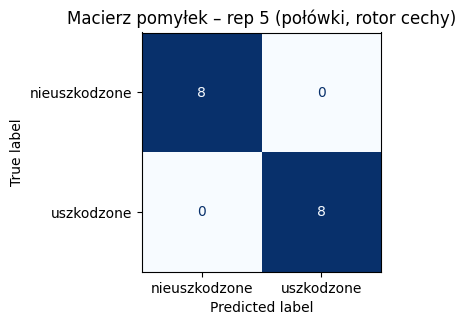


Ważność cech (RF, rotor):


A_rot_HF_ratio    0.240924
A_rot             0.215877
E_40_100          0.174756
E_0_40            0.115249
E_HF_minus_LF     0.082415
Var_200_400       0.076947
spec_flatness     0.060304
mean_db           0.029157
A_2rot            0.004371
dtype: float64

In [36]:
# Komórka 7 - Klasyfikator RF z cechami rotorowymi

from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

meta_cols = ["file_id", "condition", "pwm", "rep", "part"]

# wybrane cechy: CWT + rotor
selected_features = [
    # CWT / pasma
    "E_0_40",
    "E_40_100",
    "Var_200_400",
    "E_HF_minus_LF",
    "mean_db",
    "spec_flatness",
    # cechy rotorowe z FFT
    "A_rot",
    "A_2rot",
    "A_rot_HF_ratio",
]

feature_cols = [c for c in selected_features if c in features_df.columns]

X_train    = features_df[feature_cols].values
y_train    = features_df["condition"].values
groups_pwm = features_df["pwm"].values

print("Kształt X_train:", X_train.shape)
print("Używane cechy:", feature_cols)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        random_state=42
    ))
])

# Leave-one-PWM-out (możesz zostawić jako sanity-check)
unique_pwms = np.unique(groups_pwm)
gkf = GroupKFold(n_splits=len(unique_pwms))

scores = cross_val_score(
    clf, X_train, y_train,
    cv=gkf, groups=groups_pwm
)

print(f"\nLeave-one-PWM-out accuracy (rep 1–4, 2 połówki, rotor cechy): "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

clf.fit(X_train, y_train)

# --- Zbiór testowy: rep 5, 2 połówki, te same cechy ---

test_rows = []

test_subset = files_df[files_df["rep"] == 5].sort_values(
    ["condition", "pwm", "rep"]
)

for _, row in test_subset.iterrows():
    path    = row["path"]
    file_id = row["file_id"]
    cond    = row["condition"]
    pwm     = row["pwm"]
    rep     = row["rep"]

    t, ax, ay, az, Fs, rpm = load_xyz_from_csv(path, return_rpm=True)
    t_seg, ax_seg, ay_seg, az_seg, (t_start, t_end), mag, mag_smooth, thresh = \
        detect_steady_window(t, ax, ay, az)

    mask_seg_full = (t >= t_start) & (t <= t_end)
    f_rot = None
    if rpm is not None:
        rpm_seg = rpm[mask_seg_full]
        if len(rpm_seg) > 0:
            rpm_mean = rpm_seg.mean()
            f_rot = rpm_mean / 60.0

    N   = len(ay_seg)
    mid = N // 2
    halves = [
        (t_seg[:mid],  ay_seg[:mid]),
        (t_seg[mid:], ay_seg[mid:]),
    ]

    for part_idx, (t_part, y_part) in enumerate(halves):
        freqs, power_db = compute_cwt_freq_y(
            y_part, Fs,
            fmin=0.5,
            fmax=400,
            n_freqs=256
        )

        feat_dict = extract_features_from_cwt(freqs, power_db, bands)
        rot_feats = extract_rot_features_from_fft(y_part, Fs, f_rot)

        row_feat = {
            "file_id": file_id,
            "condition": cond,
            "pwm": pwm,
            "rep": rep,
            "part": part_idx,
        }
        row_feat.update(feat_dict)
        row_feat.update(rot_feats)

        test_rows.append(row_feat)

features_test_df = pd.DataFrame(test_rows)

# cechy stosunkowe, tak jak w treningu
if {"E_200_400", "E_0_40"}.issubset(features_test_df.columns):
    features_test_df["E_HF_minus_LF"] = features_test_df["E_200_400"] - features_test_df["E_0_40"]
else:
    features_test_df["E_HF_minus_LF"] = np.nan

if {"E_40_100", "E_0_40"}.issubset(features_test_df.columns):
    features_test_df["E_MID_minus_LF"] = features_test_df["E_40_100"] - features_test_df["E_0_40"]
else:
    features_test_df["E_MID_minus_LF"] = np.nan

print("\nZbiór testowy (rep 5, 2 połówki na sygnał):")
display(features_test_df[feature_cols].head())

X_test = features_test_df[feature_cols].values
y_test = features_test_df["condition"].values

y_pred = clf.predict(X_test)

print("\n=== Wyniki na zbiorze testowym (rep 5, połówki, rotor cechy) ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["nieuszkodzone", "uszkodzone"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["nieuszkodzone", "uszkodzone"])
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Macierz pomyłek – rep 5 (połówki, rotor cechy)")
plt.tight_layout()
plt.show()

rf_model = clf.named_steps["rf"]
importances = rf_model.feature_importances_
imp_series = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
print("\nWażność cech (RF, rotor):")
display(imp_series)


In [37]:
# Komórka 8 - Zapis modelu RF (cechy rotorowe + CWT)
from joblib import dump
import json
from pathlib import Path

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

model_path = MODEL_DIR / "propeller_damage_rpm_rf.joblib"
dump(clf, model_path)
print("Zapisano model do:", model_path)

meta = {
    "feature_cols": feature_cols,
    "bands": bands,
    "fft_params": {
        "hp_cut_hz": 5.0,           # częstotliwość odcięcia filtru HP
        "pad_factor": 8,            # zero-padding w FFT
        "rot_band_width_hz": 2.0,   # +/- szerokość pasma wokół f_rot
        "hf_band": [200.0, 400.0],  # pasmo HF dla A_rot_HF_ratio
    },
}

meta_path = MODEL_DIR / "propeller_damage_rpm_rf_meta.json"
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("Zapisano metadane do:", meta_path)


Zapisano model do: models\propeller_damage_rpm_rf.joblib
Zapisano metadane do: models\propeller_damage_rpm_rf_meta.json


In [46]:
# Komórka 9 - Użycie zapisanego modelu na nowym sygnale
from joblib import load
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import json

# wczytanie modelu i metadanych
MODEL_DIR = Path("models")
model_path = MODEL_DIR / "propeller_damage_rpm_rf.joblib"
meta_path  = MODEL_DIR / "propeller_damage_rpm_rf_meta.json"

clf_loaded = load(model_path)
with open(meta_path, "r", encoding="utf-8") as f:
    meta = json.load(f)

feature_cols_loaded = meta["feature_cols"]

print("Załadowano model z:", model_path)
print("Kolumny cech:", feature_cols_loaded)

# ścieżka do pliku z kupionym śmigłem
test_file = Path("data/pomiary_finalne/fabryczne_smiglo_druga/pwm_40%/3_fabryczne_druga_40%.csv")
print("Analizowany plik:", test_file)

# wczytanie z RPM i detekcja pracy ustalonej
t, ax, ay, az, Fs, rpm = load_xyz_from_csv(test_file, return_rpm=True)
t_seg, ax_seg, ay_seg, az_seg, (t_start, t_end), mag, mag_smooth, thresh = \
    detect_steady_window(t, ax, ay, az)

print(f"Okno ustalonej pracy: {t_start:.2f}–{t_end:.2f} s, liczba próbek: {len(t_seg)}")

# RPM w oknie pracy ustalonej → f_rot
mask_seg_full = (t >= t_start) & (t <= t_end)
f_rot = None
if rpm is not None:
    rpm_seg = rpm[mask_seg_full]
    if len(rpm_seg) > 0:
        rpm_mean = rpm_seg.mean()
        f_rot = rpm_mean / 60.0
        print(f"Średnie RPM w oknie pracy ustalonej: {rpm_mean:.1f} RPM (~{f_rot:.2f} Hz)")

# dzielenie na 2 połówki jak w treningu
N   = len(ay_seg)
mid = N // 2
halves = [
    (t_seg[:mid],  ay_seg[:mid]),
    (t_seg[mid:], ay_seg[mid:]),
]

rows_single = []

for part_idx, (t_part, y_part) in enumerate(halves):
    # CWT
    freqs, power_db = compute_cwt_freq_y(
        y_part, Fs,
        fmin=0.5,
        fmax=400,
        n_freqs=256
    )

    feat_dict = extract_features_from_cwt(freqs, power_db, bands)
    rot_feats = extract_rot_features_from_fft(y_part, Fs, f_rot)

    row_feat = {
        "file_id": str(test_file),
        "part": part_idx,
    }
    row_feat.update(feat_dict)
    row_feat.update(rot_feats)

    rows_single.append(row_feat)

features_single_df = pd.DataFrame(rows_single)

# cechy stosunkowe HF/LF tak jak w treningu
if {"E_200_400", "E_0_40"}.issubset(features_single_df.columns):
    features_single_df["E_HF_minus_LF"] = features_single_df["E_200_400"] - features_single_df["E_0_40"]
else:
    features_single_df["E_HF_minus_LF"] = np.nan

if {"E_40_100", "E_0_40"}.issubset(features_single_df.columns):
    features_single_df["E_MID_minus_LF"] = features_single_df["E_40_100"] - features_single_df["E_0_40"]
else:
    features_single_df["E_MID_minus_LF"] = np.nan

print("\nCechy wyliczone dla dwóch połówek sygnału:")
display(features_single_df[feature_cols_loaded])

# predykcja dla każdej połówki
X_single = features_single_df[feature_cols_loaded].values
y_pred_single = clf_loaded.predict(X_single)
y_proba_single = clf_loaded.predict_proba(X_single)

classes_list = clf_loaded.classes_.tolist()
idx_ok  = classes_list.index("nieuszkodzone")
idx_dmg = classes_list.index("uszkodzone")

for i, (label, proba) in enumerate(zip(y_pred_single, y_proba_single)):
    print(
        f"Połówka {i}: predykcja = {label}, "
        f"P(nieuszkodzone) = {proba[idx_ok]:.3f}, "
        f"P(uszkodzone) = {proba[idx_dmg]:.3f}"
    )

# głosowanie większościowe dla całego sygnału
maj_label = Counter(y_pred_single).most_common(1)[0][0]
print("\n>>> Predykcja dla całego sygnału:", maj_label)


Załadowano model z: models\propeller_damage_rpm_rf.joblib
Kolumny cech: ['E_0_40', 'E_40_100', 'Var_200_400', 'E_HF_minus_LF', 'mean_db', 'spec_flatness', 'A_rot', 'A_2rot', 'A_rot_HF_ratio']
Analizowany plik: data\pomiary_finalne\fabryczne_smiglo_druga\pwm_40%\3_fabryczne_druga_40%.csv
Okno ustalonej pracy: 0.00–11.12 s, liczba próbek: 17797
Średnie RPM w oknie pracy ustalonej: 2367.0 RPM (~39.45 Hz)

Cechy wyliczone dla dwóch połówek sygnału:


E_0_40   E_40_100  Var_200_400  E_HF_minus_LF    mean_db  spec_flatness  \
0 -26.783663 -20.034469   153.097545       3.105826 -20.320756       0.170038   
1 -29.770472 -27.286915   217.556594       0.492188 -27.244504       0.506871   

      A_rot    A_2rot  A_rot_HF_ratio  
0  0.052495  0.063111        1.608865  
1  0.054498  0.038562        1.856888

Połówka 0: predykcja = nieuszkodzone, P(nieuszkodzone) = 0.790, P(uszkodzone) = 0.210
Połówka 1: predykcja = nieuszkodzone, P(nieuszkodzone) = 0.703, P(uszkodzone) = 0.297

>>> Predykcja dla całego sygnału: nieuszkodzone
